<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Utilities" data-toc-modified-id="Imports-and-Utilities-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Utilities</a></span></li><li><span><a href="#Channels" data-toc-modified-id="Channels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Channels</a></span></li><li><span><a href="#Differential-Insertion-Loss" data-toc-modified-id="Differential-Insertion-Loss-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Differential Insertion Loss</a></span></li><li><span><a href="#Impulse-Responses" data-toc-modified-id="Impulse-Responses-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Impulse Responses</a></span></li><li><span><a href="#Step-Responses" data-toc-modified-id="Step-Responses-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Step Responses</a></span></li><li><span><a href="#Extracting-a-Channel-of-Interest" data-toc-modified-id="Extracting-a-Channel-of-Interest-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extracting a Channel of Interest</a></span></li><li><span><a href="#Batch-Checking-4-port-Model-Port-Numbering" data-toc-modified-id="Batch-Checking-4-port-Model-Port-Numbering-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Batch Checking 4-port Model Port Numbering</a></span></li></ul></div>

# S-parameter Checking

Original author: David Banas <capn.freako@gmail.com>  
Original date:   November 30, 2017

Copyright &copy; 2017 David Banas; all rights reserved World wide.

This [Jupyter](http://jupyter.org) notebook can be used to sanity check a batch of 4-port single-ended [Touchstone](https://en.wikipedia.org/wiki/Touchstone_file) files, and generate their equivalent differential step responses, for use w/ [PyBERT](https://github.com/capn-freako/PyBERT/wiki).

## Imports and Utilities

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

import skrf as rf
import numpy as np
import scipy.signal as sig


plt.figure(figsize=(16, 8))

def sdd_21(ntwk):
    """
    Given a 4-port single-ended network, return its differential throughput.

    Args:
        ntwk(skrf.Network): 4-port single ended network.

    Returns:
        [float]: Sdd[2,1].
    """
    if np.real(ntwk.s21.s[0, 0, 0]) < 0.5:  # 1 ==> 3 port numbering?
        #ntwk.renumber((2, 3), (3, 2))
        ntwk.renumber((1, 2), (2, 1))

    return 0.5 * (ntwk.s21 - ntwk.s23 + ntwk.s43 - ntwk.s41)

<Figure size 1600x800 with 0 Axes>

## Channels

Load the channels of interest and sanity check them.

Channel    Passive   
_____________________
   via        True   


/Users/dbanas/miniconda3/envs/pybert/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


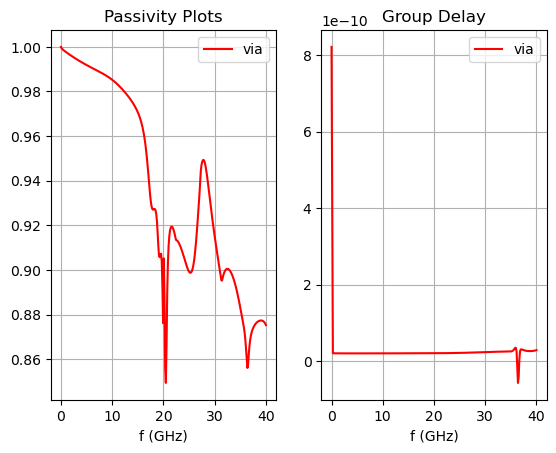

In [2]:
# Load the channels of interest.
chnls = []
# chnls.append(('ch1', rf.Network('../channels/802.3bj_COM_Cisco/kochuparambil_3bj_02_0913/Beth_longSmooth_THRU.s4p')))
# chnls.append(('ch2', rf.Network('../channels/802.3bj_COM_Cisco/kochuparambil_3bj_02_0913/Beth_shortReflective_THRU.s4p')))
# chnls.append(('ch5', rf.Network('../channels/shanbhag_01_0511/TEC_Whisper27in_THRU_G14G15.s4p')))
# chnls.append(('se', rf.Network('../Support/DoriItzhaki/tx_se.s4p')))
chnls.append(('via', rf.Network('/Users/dbanas/Documents/Keysight/CustomerSupport/Fortinet/Via_Void_36.5_LinSweep.s4p')))

# Create diagonal mask, for checking passivity, below.
n = chnls[0][1]
m = np.zeros(n.s[0].shape, dtype=bool)
np.fill_diagonal(m, True)

# Check them against several criteria.
passivities = []
clrs = ['r','g','b','c','m','y']
for (lbl, ntwk), clr in zip(chnls, clrs):
    passivity = np.array(list(map(lambda x: max(x[m]), ntwk.passivity)))
    # passivities.append(ntwk.is_passive())  # Apparently, not implemented, yet.
    if(max(passivity) <= 1.0):
        passivities.append(True)
    else:
        passivities.append(False)
    plt.subplot(121)
    plt.plot(ntwk.f / 1e9, passivity, clr, label=lbl)

    plt.subplot(122)
    plt.plot(ntwk.f / 1e9, sdd_21(ntwk).group_delay.flatten(), clr, label=lbl)

#Plot passivities.
plt.subplot(121)
plt.title("Passivity Plots")
plt.xlabel("f (GHz)")
plt.grid()
plt.legend(loc='upper right')

#Plot group delays.
plt.subplot(122)
plt.title("Group Delay")
plt.xlabel("f (GHz)")
plt.grid()
plt.legend(loc='upper right')

# Print a summary of the results.
print("{:10s} {:10s}".format('Channel','Passive'))
print('_'*21)
for ((lbl, ntwk), passive) in zip(chnls, passivities):
    print("{:^10s} {:^10s}".format(lbl, str(passive)))

Channel is passive, but has a serious anomaly in its group delay.

## Differential Insertion Loss

Convert to mixed mode and display Sdd[2,1].

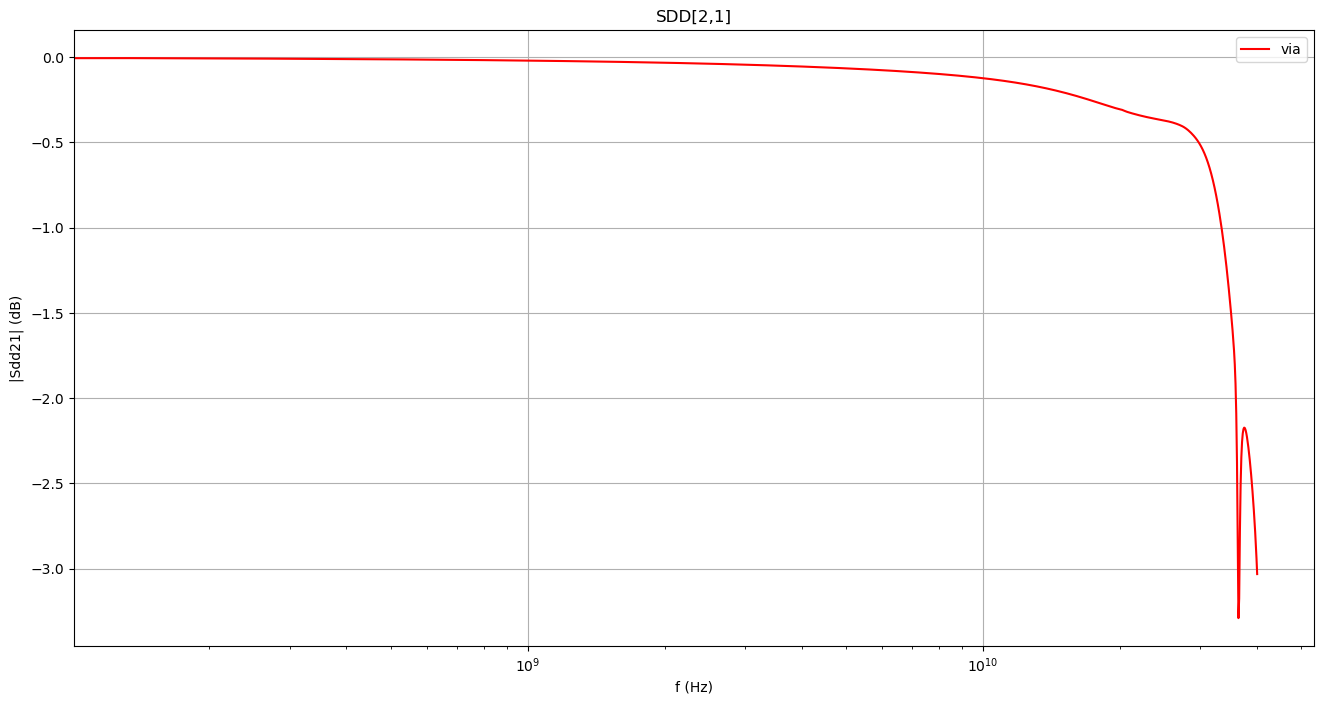

In [3]:
# Plot their differential insertion losses.
sdd_21s = []
plt.figure(figsize=(16, 8))
for (lbl, ntwk), clr in zip(chnls, clrs):
    H = sdd_21(ntwk)
    sdd_21s.append(H)
    plt.semilogx(ntwk.f, 20 * np.log10(abs(H.s[:,0,0])), clr, label=lbl)
plt.title("SDD[2,1]")
plt.xlabel("f (Hz)")
plt.ylabel("|Sdd21| (dB)")
plt.grid()
plt.legend(loc='upper right')
#plt.axis(ymin=-40)
plt.show()

This does *not* look correct.  
The anomaly in the *Sdd[2,1]* plot, above, corresponds in frequency with the anomaly in the *group delay* plot, above.

## Impulse Responses

via ref. frequencies: 0.0-40.0 GHz, 300 pts
via frequencies: 0.13377926421405-39.8662207357869 GHz, 298 pts


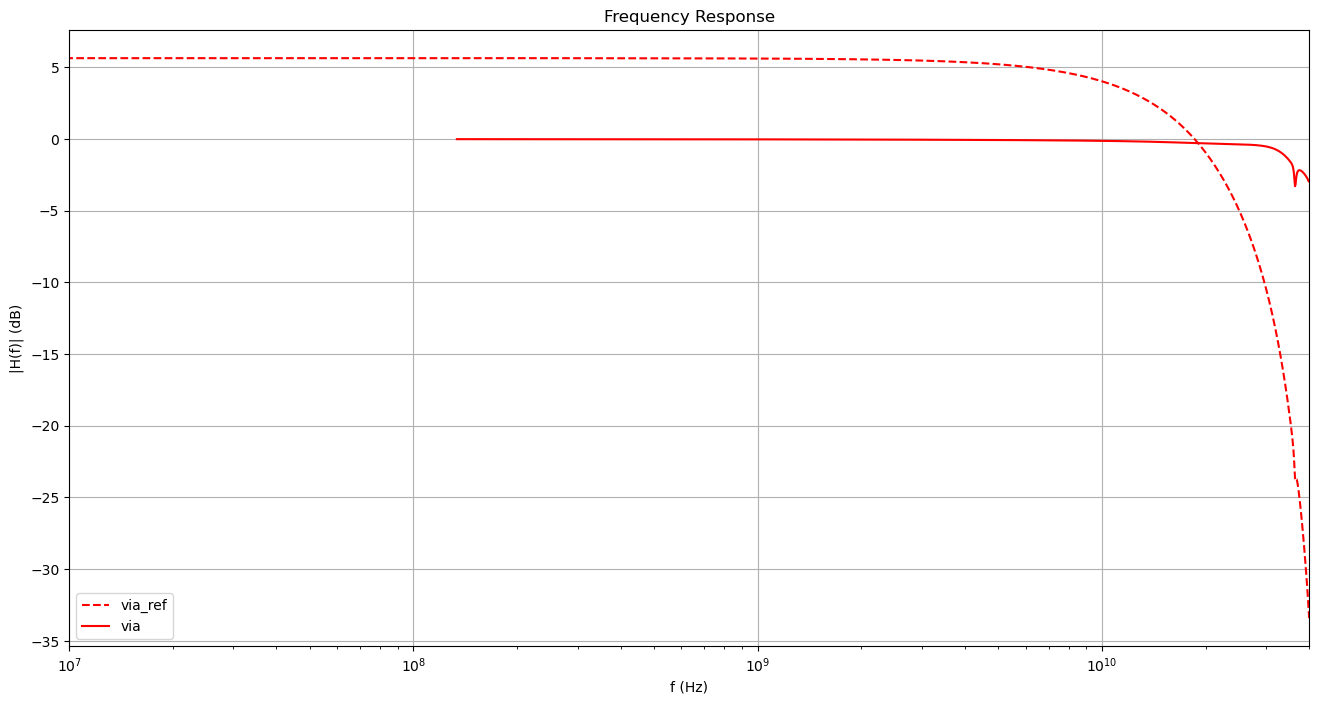

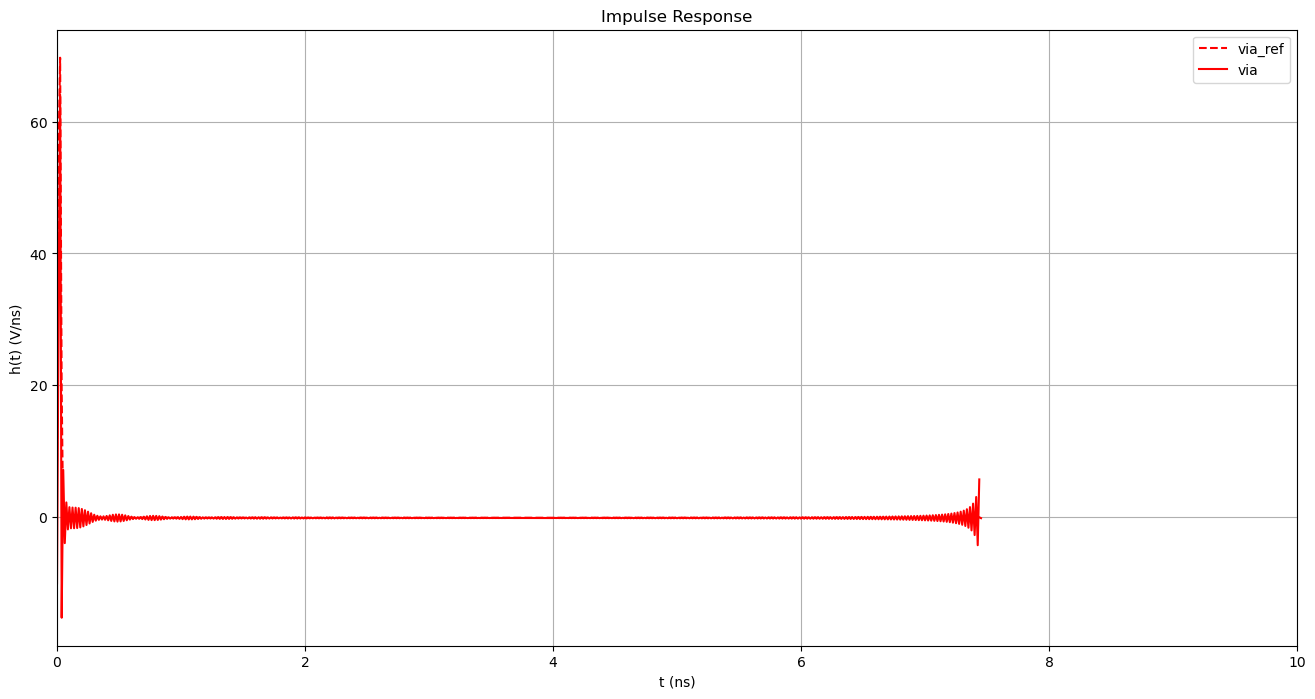

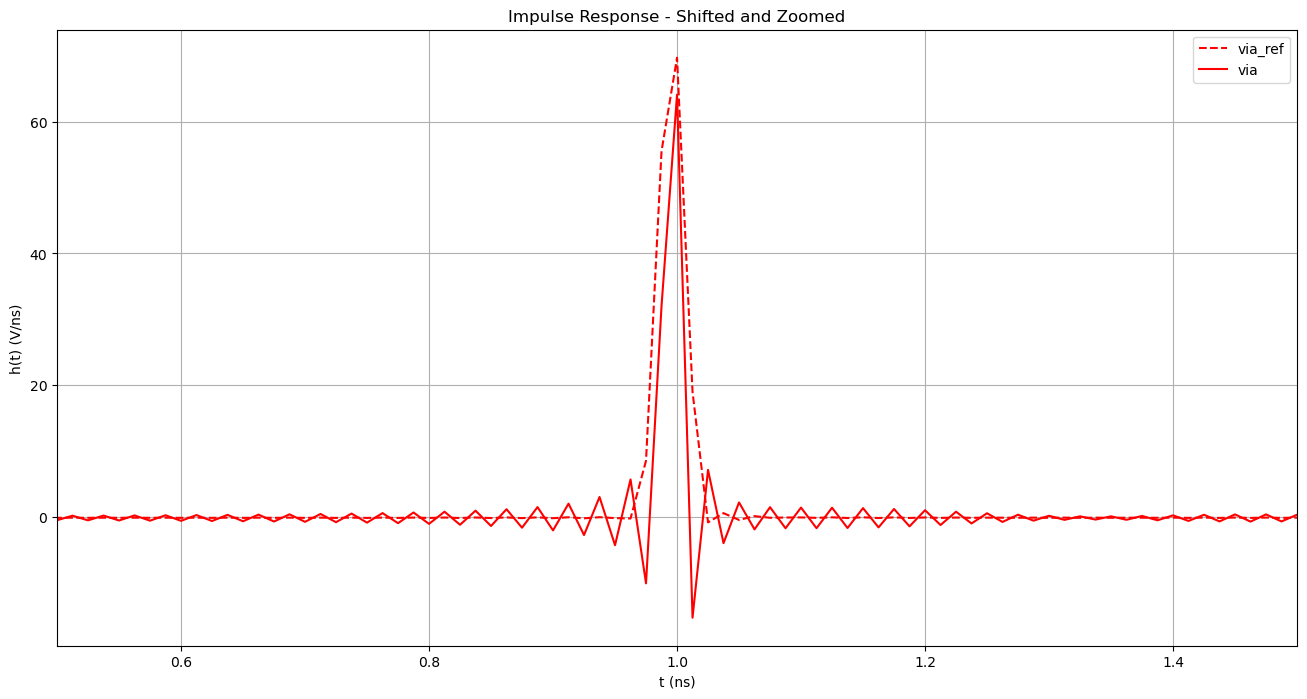

In [14]:
# Here, I calculate the impulse response myself,
# as opposed to using the 'Network.s_time()' function provided by skrf,
# because I've found I get better results.

ts = []
fs = []
hs = []
ss = []
trefs = []
frefs = []
hrefs = []
srefs = []

for (lbl, _), sdd_21, clr in zip(chnls, sdd_21s, clrs):
    # Testing/comparing one-line solution, using scikit-rf.
    #sdd_21_ref = sdd_21.extrapolate_to_dc().windowed()
    #sdd_21_ref = sdd_21.extrapolate_to_dc()
    sdd_21_ref = sdd_21.windowed()
    Href  = sdd_21_ref.s[:,0,0]
    fref  = sdd_21_ref.f
    Fref  = rf.Frequency.from_f(fref / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} ref. frequencies: {}".format(lbl, Fref))
    # Hrefp = Href.copy()
    # if(fref[0] != 0):  # Add the d.c. point, if necessary.
    #     Hrefp  = np.pad(Hrefp, (1,0), 'constant', constant_values=1.0)  # Presume d.c. value = 1.
    href  = np.fft.irfft(Href)
    #href /= np.abs(href.sum())  # Equivalent to assuming that step response settles at 1.

    # Form frequency vector.
    f = sdd_21.f
    fmin = f[0]
    if(fmin == 0):  # Correct, if d.c. point was included in original data.
        fmin = f[1]
    fmax = f[-1]
    # f = np.arange(fmin, fmax + fmin, fmin)
    f = np.arange(fmin, fmax, fmin)
    F = rf.Frequency.from_f(f / 1e9)  ## skrf.Frequency.from_f() expects its argument to be in units of GHz.
    print("{} frequencies: {}".format(lbl, F))

    # Form impulse response from frequency response.
    # sdd_21 = sdd_21.interpolate_from_f(F)
    sdd_21 = sdd_21.interpolate(F)
    H = sdd_21.s[:,0,0]
    # H = np.concatenate((H, np.conj(np.flip(H[:-1], 0))))  # Forming the vector that fft() would've outputted.
    Hp = H.copy()
    Hp = np.pad(Hp, (1,0), 'constant', constant_values=0.0)  # Presume d.c. value = 1.
    # h = np.real(np.fft.ifft(H))
    h = np.fft.irfft(Hp)
    # h /= np.abs(h.sum())  # Equivalent to assuming that step response settles at 1.
    
    # Form step response from impulse response.
    s = np.cumsum(h)
    sref = np.cumsum(href)
    
    # Form time vector.
    t0 = 1. / (2. * fmax)  # Sampling interval = 1 / (2 fNyquist).
    t = np.array([n * t0 for n in range(len(h))])
    tref = np.array([n * t0 for n in range(len(href))])

    # Save results.
    ts.append(t)
    fs.append(f)
    hs.append(h)
    ss.append(s)
    trefs.append(tref)
    frefs.append(fref)
    hrefs.append(href)
    srefs.append(sref)

    # Plot results.
    def shift_peak(t, x, new_peak_loc=1e-9):
        t_peak = t[np.argmax(x)]
        delta_t = new_peak_loc - t_peak
        return np.roll(x, int(delta_t / t[1]))
        
    plt.figure(1, figsize=(16, 8))
    plt.semilogx(fref, 20. * np.log10(np.abs(Href)), clr+'--', label=lbl+'_ref')
    plt.semilogx(f,    20. * np.log10(np.abs(H)),    clr,      label=lbl)

    plt.figure(2, figsize=(16, 8))
    plt.plot(tref * 1e9, href / t0 * 1e-9, clr+'--', label=lbl+'_ref')
    plt.plot(t * 1e9,    h / t0 * 1e-9,    clr,      label=lbl)

    plt.figure(3, figsize=(16, 8))
    plt.plot(tref * 1e9, shift_peak(tref, href) / t0 * 1e-9, clr+'--', label=lbl+'_ref')
    plt.plot(t * 1e9,    shift_peak(t, h)       / t0 * 1e-9, clr,      label=lbl)

# Annotate the plots.
plt.figure(1, figsize=(16, 8))
plt.title("Frequency Response")
plt.xlabel("f (Hz)")
plt.ylabel("|H(f)| (dB)")
plt.grid()
plt.legend(loc='lower left')
plt.axis(xmin=1e7, xmax=40e9);

plt.figure(2, figsize=(16, 8))
plt.title("Impulse Response")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0, xmax=10);

plt.figure(3, figsize=(16, 8))
plt.title("Impulse Response - Shifted and Zoomed")
plt.xlabel("t (ns)")
plt.ylabel("h(t) (V/ns)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(xmin=0.5, xmax=1.5);


Hmmm, I think this file has some problems. :(

## Step Responses

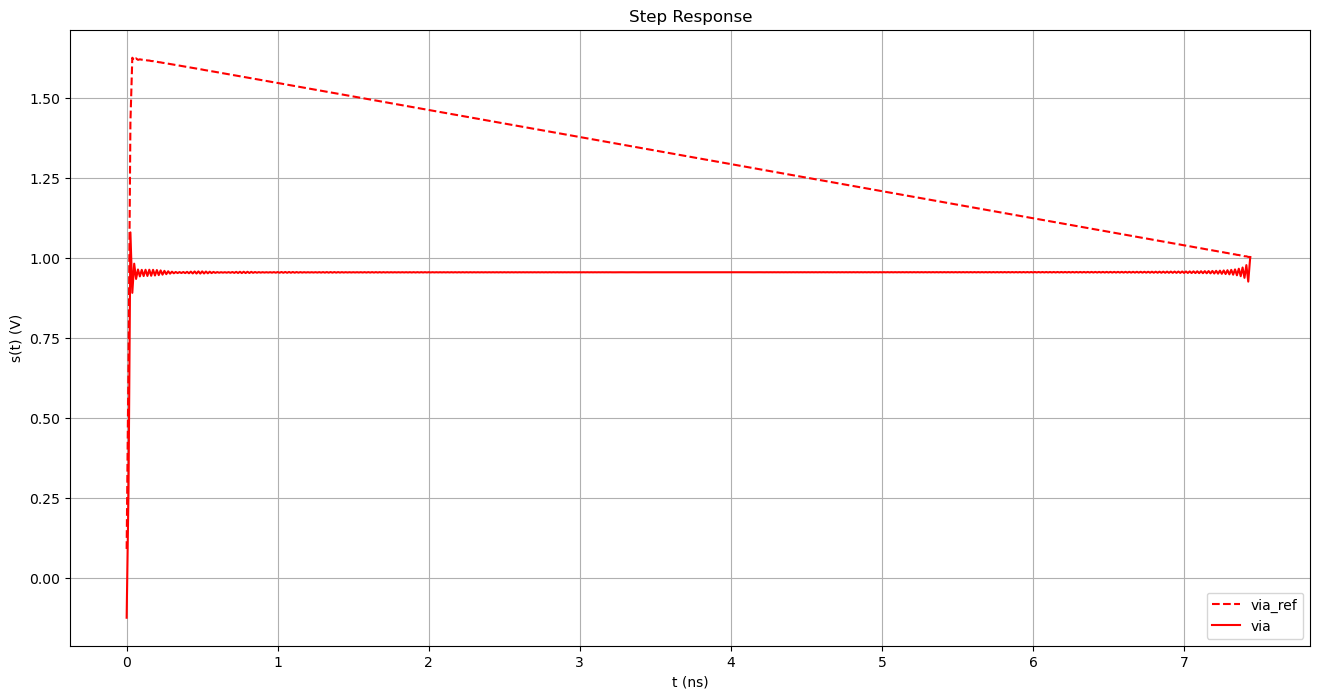

In [8]:
plt.figure(figsize=(16, 8))
for (lbl, _), t, s, tref, sref, clr in zip(chnls, ts, ss, trefs, srefs, clrs):
    plt.plot(tref * 1e9, sref, clr+'--', label=lbl+'_ref')
    plt.plot(t    * 1e9, s,    clr,      label=lbl)
plt.title("Step Response")
plt.xlabel("t (ns)")
plt.ylabel("s(t) (V)")
plt.grid()
plt.legend(loc='lower right');
# plt.axis(xmin=1.8, xmax=2.0)

This doesn't look right.

In [9]:
# Save the step responses.
for (lbl, _), t, s in zip(chnls, trefs, srefs):
    with open(lbl+'_s.csv', 'wt') as file:
        for x, y in zip(t, s):
            # print >> file, "{:014.12f}, {:05.3f}".format(x, y)
            print("{:014.12f}, {:05.3f}".format(x, y), file=file)

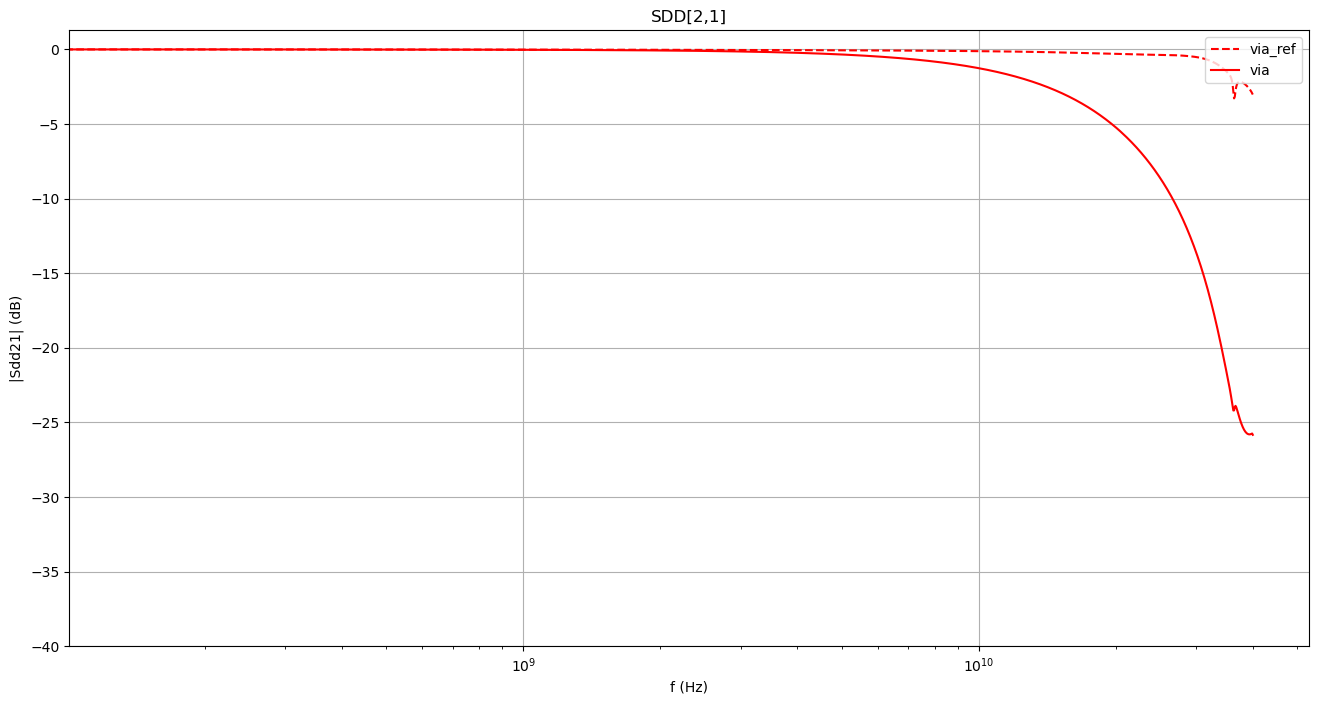

In [10]:
# Take them back into the frequency domain and compare to original data.
hps = []
plt.figure(figsize=(16, 8))
for f, s, (lbl, _), Href, clr in zip(frefs, srefs, chnls, sdd_21s, clrs):
    h = np.diff(s)
    h = np.pad(h, (1, 0), 'constant', constant_values=0)
    H = np.fft.fft(h)
    # Using [1], as opposed to [0], to accomodate ch1. (See, below.)
    # I'm assuming the strange behavior in ch1 is due to me forcing d.c. values of 1.
    H *= abs(Href.s[:,0,0][1]) / abs(H[1])  # Normalize the "d.c." levels.
    plt.semilogx(Href.f, 20 * np.log10(abs(Href.s[:,0,0])), clr+'--', label=lbl+'_ref')
    plt.semilogx(f,      20 * np.log10(abs(H[:len(f)])),    clr,      label=lbl)

plt.title("SDD[2,1]")
plt.xlabel("f (Hz)")
plt.ylabel("|Sdd21| (dB)")
plt.grid()
plt.legend(loc='upper right')
plt.axis(ymin=-40);


This Touchstone file has serious problems!

## Extracting a Channel of Interest

Here we show how to extract a channel of interest from a multi-port model.


In [ ]:
tfilename = "../Channels/ODSA_BOW_20mm_Organic/osda_bow_04_models/osda_bow_04_A_Layer1.s10p"

ntwk = rf.Network(tfilename)
psvty = ntwk.passivity
print(np.max(psvty))

ntwk.plot_s_mag(0,0)
ntwk.plot_s_mag(1,0)
ntwk.plot_s_mag(5,0)


## Batch Checking 4-port Model Port Numbering

Here we check a batch of `*.s4p` files for the convention used in port 2/3 choice, as well as the accuracy of our `sdd_21()` function, above.

In [ ]:
tfilenames = []
#tfilenames.append(('ch1', "../Channels/deembedded_Diff_1_Assembly_1_Interposer_24.s4p"))
#tfilenames.append(('ch2', "../Support/HanselDsilva/PyBert_Request_For_Help/Cable_BKP_16dB_0p575m_more_isi_thru1.s4p"))
#tfilenames.append(('ch3', "../Support/Shujun/peters_01_0605_B1_thru.s4p"))
#tfilenames.append(('ch4', "../Support/SimonFau/TI_LMH1219_LMH1226_IBIS_AMI_v1/Model/PkgIN.s4p"))
tfilenames.append(('ch5', "../Support/YoelBiberman/BCM81181_AMI_IBIS_Models_v1p0/BCM81181_Package_S_parameters/BCM81181/Lineside/Lineside/BCM81181_pkg_LRX0.s4p"))
for (lbl, tfilename) in tfilenames:
    ntwk = rf.Network(tfilename)
    ntwk.plot_s_mag(1,0, label=f'{lbl}.S21')
    ntwk.plot_s_mag(2,0, label=f'{lbl}.S31')
    sdd_21(ntwk).plot_s_mag(0,0, label=f'{lbl}.sdd_21()')


In [ ]:
ntwk = rf.Network("../Support/DoriItzhaki/tx_se.s4p")
for m in range(4):
    for n in range(4):
        if np.abs(ntwk.s[0, m, n]) > 0.5:
            ntwk.plot_s_mag(m, n)

In [ ]:
rf.one_port_2_two_port(subnet).write_touchstone()

In [ ]:
subnet.s.shape